# La Liga Wins Analysis

This project analyzes match performance data from La Liga to understand the key factors that lead a team to victory. Using match statistics such as goals scored, possession, shots, and distance covered, we explore trends among the top-performing teams by win rate. The analysis includes:

1. Exploratory Data Analysis (EDA) to uncover patterns and outliers

2. Correlation and categorical breakdowns to identify winning styles

3. Predictive modeling using Linear, Polynomial, and Ridge Regression to evaluate how well match stats can predict goal outcomes

Our goal is to identify what consistently drives teams to win in La Liga, whether it's dominance in possession, shooting efficiency, or tactical consistency at home and away.

## About the Dataset

This dataset contains detailed match-level data from **La Liga** football matches, including team performance metrics like goals, possession, xG (expected goals), and more.

**Source**: [Kaggle Dataset - Matches Full](https://www.kaggle.com/datasets/marcelbiezunski/laliga-matches-dataset-2019-2025-fbref)

### Column Descriptions

- `date`, `time`: Match date and kickoff time
- `comp`: Competition (La Liga)
- `round`: Matchweek number
- `day`: Day of the week
- `venue`: Home or Away
- `result`: Match result (W/D/L)
- `gf`, `ga`: Goals for and against
- `xg`, `xga`: Expected goals for and against
- `poss`: Possession percentage
- `attendance`: Number of spectators
- `captain`, `referee`: Metadata about the match
- `formation`, `opp formation`: Team formations
- `sh`, `sot`: Shots, shots on target
- `dist`: Average distance covered
- `fk`, `pk`, `pkatt`: Free kicks, penalties and attempts
- `season`: Year of the season
- `team`, `opponent`: Team and opponent name


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
data_set = "/Users/user/Downloads/matches_full.csv"
df = pd.read_csv(data_set, header=0)
df.head()

,Unnamed: 0,date,time,comp,round,day,venue,result,gf,ga,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
0,0,2024-08-17,21:30,La Liga,Matchweek 1,Sat,Away,W,2.0,1.0,...,Match Report,NaN,17.0,5.0,18.6,1.0,1,1,2025,Barcelona
1,1,2024-08-24,19:00,La Liga,Matchweek 2,Sat,Home,W,2.0,1.0,...,Match Report,NaN,13.0,5.0,16.6,0.0,0,0,2025,Barcelona
2,2,2024-08-27,21:30,La Liga,Matchweek 3,Tue,Away,W,2.0,1.0,...,Match Report,NaN,22.0,5.0,19.3,1.0,0,0,2025,Barcelona
3,3,2024-08-31,17:00,La Liga,Matchweek 4,Sat,Home,W,7.0,0.0,...,Match Report,NaN,23.0,11.0,13.7,1.0,0,0,2025,Barcelona
4,4,2024-09-15,16:15,La Liga,Matchweek 5,Sun,Away,W,4.0,1.0,...,Match Report,NaN,20.0,9.0,19.1,0.0,0,0,2025,Barcelona


### Data Cleaning

Before doing any analysis, let's clean the data. 

In [11]:
# Check the total number of missing values per column
missing_values = df.isnull().sum()

# Display columns with missing values only
missing_values = missing_values[missing_values > 0]

# Show the result
print("Missing values per column:")
print(missing_values)

Missing values per column:
attendance     974
referee         54
notes         4318
dist             3
dtype: int64


In [13]:
# Now let's handle these missing values

df['attendance'].fillna(df['attendance'].mean(), inplace=True)
df['referee'].fillna(df['referee'].mode()[0], inplace=True)
df['dist'].fillna(df['dist'].mean(), inplace=True)

#Then we will drop the notes columns as it will not impact our analysis. 
df = df.drop(columns=["notes"])

/var/folders/kb/9t6clgkx67j9xy4wx6c1dkym0000gn/T/ipykernel_90809/3766326910.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['attendance'].fillna(df['attendance'].mean(), inplace=True)
/var/folders/kb/9t6clgkx67j9xy4wx6c1dkym0000gn/T/ipykernel_90809/3766326910.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

## Objective

Since our goal is to understand what improves the odds of a team winning, we will try to understand the number of wins of the top 10 clubs.

In [33]:
#Total matches played per team
matches_played = df.groupby('team').size()

# Total wins
wins = df[df['result'] == 'W'].groupby('team').size()

# Win rate
win_rate = (wins / matches_played).round(3)

# Goal difference = total goals for - total goals against
goal_diff = df.groupby('team').agg({'gf': 'sum', 'ga': 'sum'})
goal_diff['goal_difference'] = goal_diff['gf'] - goal_diff['ga']

# Average possession
avg_poss = df.groupby('team')['poss'].mean().round(2)

# Combine into one DataFrame
summary = pd.DataFrame({
    'wins': wins,
    'matches_played': matches_played,
    'win_rate': win_rate,
    'goal_difference': goal_diff['goal_difference'],
    'avg_poss': avg_poss
}).fillna(0).astype({'wins': 'int', 'matches_played': 'int'})

# Select top 10 teams by win rate
top10_summary = summary.sort_values(by='win_rate', ascending=False).head(10)

# Display the result
print(top10_summary)

                 wins  matches_played  win_rate  goal_difference  avg_poss
team                                                                      
Real Madrid       146             216     0.676            263.0     59.82
Barcelona         142             216     0.657            256.0     65.16
Atletico Madrid   128             216     0.593            179.0     50.73
Girona             47             102     0.461             37.0     54.84
Real Sociedad      97             216     0.449             56.0     55.00
Villarreal         94             215     0.437             88.0     53.60
Sevilla            92             216     0.426             45.0     55.74
Real Betis         87             216     0.403             19.0     52.76
Athletic Club      84             216     0.389             63.0     49.55
Osasuna            70             216     0.324            -54.0     46.61


## Exploratory Data Analysis (EDA)

### Data Distributions

This section explores how key performance metrics are distributed in matches won by the Top 10 teams by win rate. By analyzing goals scored, possession, shots, shots on target, and distance covered, we gain insight into the performance patterns that typically lead to victory. These visualizations help define what a “winning performance” looks like among the most consistently successful teams in the league.

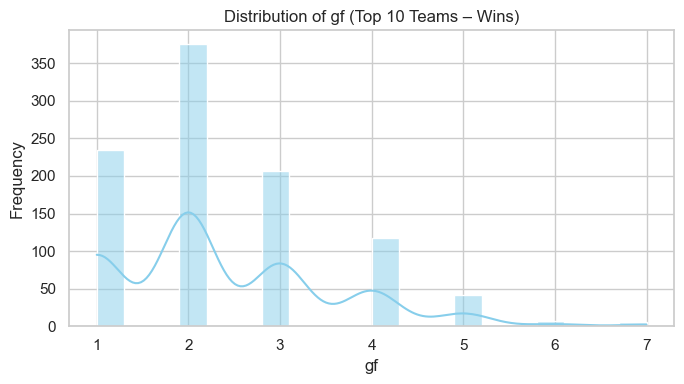

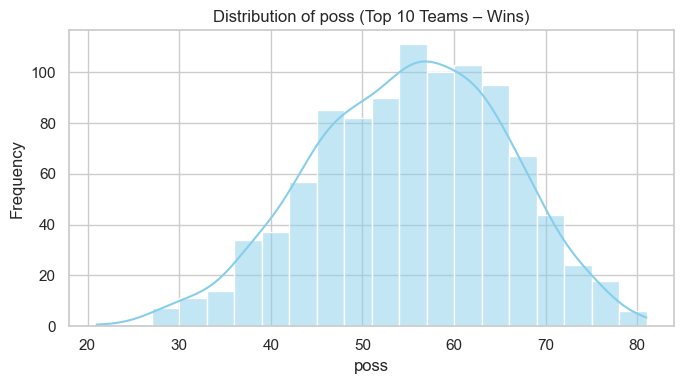

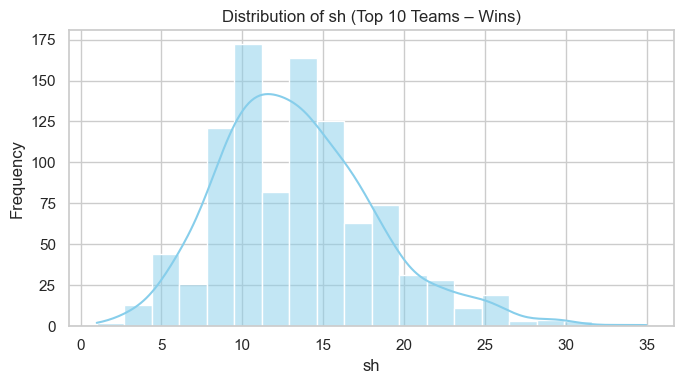

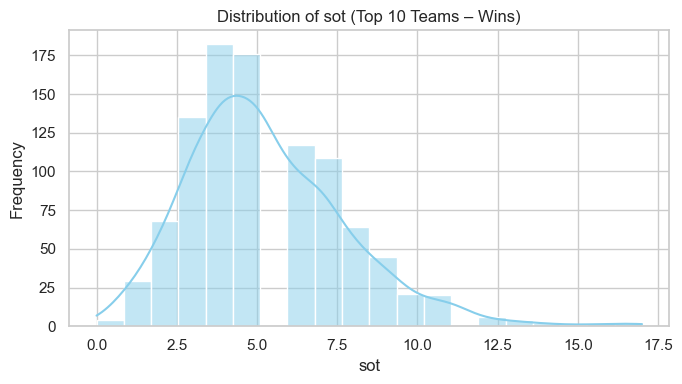

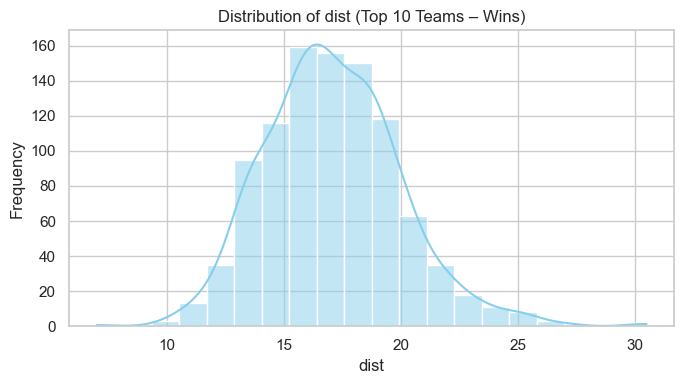

In [38]:
#Select top 10 teams
top10_teams = summary.sort_values(by='win_rate', ascending=False).head(10).index.tolist()

# Filter dataset to only winning matches of top 10 teams
top10_wins_df = df[(df['team'].isin(top10_teams)) & (df['result'] == 'W')].dropna(
    subset=['gf', 'poss', 'sh', 'sot', 'dist']
)

#Plot distributions
metrics = ['gf', 'poss', 'sh', 'sot', 'dist']

for col in metrics:
    plt.figure(figsize=(7, 4))
    sns.histplot(data=top10_wins_df, x=col, kde=True, bins=20, color='skyblue')
    plt.title(f"Distribution of {col} (Top 10 Teams – Wins)")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

The distributions reveal that most wins occur when teams score 2 or more goals, attempt 10–15 total shots, and land 4–6 shots on target. Possession in winning matches is commonly between 55–65%, suggesting that controlling the ball is a recurring trait among high-performing teams. Meanwhile, the distance covered varies more widely, with no dominant pattern — indicating that physical output supports, but does not solely determine, success. Collectively, these patterns point to offensive efficiency and possession control as common ingredients in consistent victories.

### Outlier Analysis 

Outlier analysis highlights the exceptional or uncommon performances that still resulted in victories. By identifying these extreme values, such as matches with unusually high goals, shots, or low possession, we can better understand the range of ways that top teams can win, even when deviating from typical patterns.

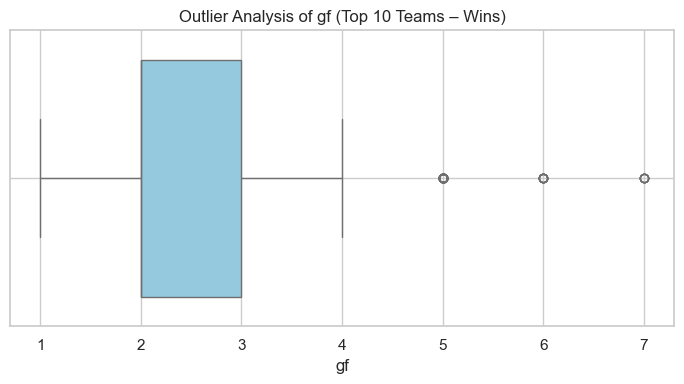

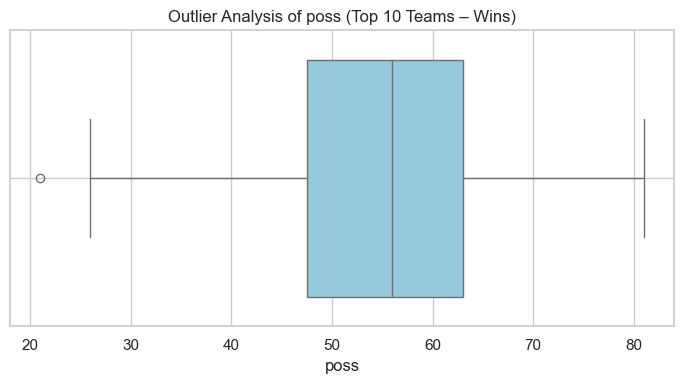

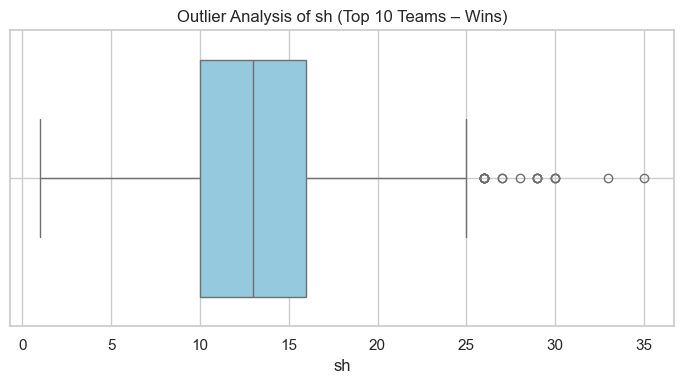

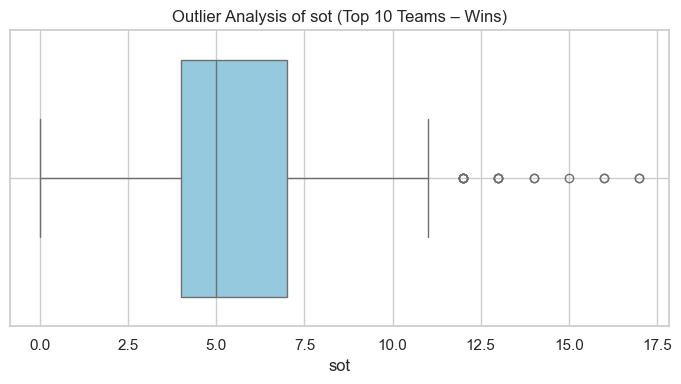

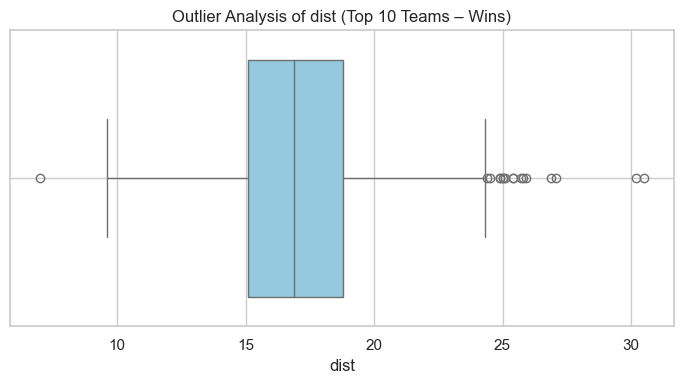

In [39]:
# Generate boxplots
for col in metrics:
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=top10_wins_df, x=col, color='skyblue')
    plt.title(f"Outlier Analysis of {col} (Top 10 Teams – Wins)")
    plt.xlabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

The boxplots show that while most wins fall within consistent performance ranges, some matches stand out. For instance, a few games featured 5 or more goals or 25+ shots, indicating highly dominant wins. On the other end, some teams won with under 40% possession or minimal physical output, showing that tactical efficiency can prevail over control or intensity. These outliers reflect the adaptability of elite teams, capable of winning both through dominance and through compact, efficient strategies.

### Relationships between variables

#### Correlation Matrix
This correlation matrix explores the relationships between key match statistics in games won by the most successful teams. By identifying which metrics tend to move together, we gain insight into how teams build toward victory, whether through possession, shot volume, or physical effort.

In [42]:
#Compute correlation matrix
correlation_metrics = ['gf', 'poss', 'sh', 'sot', 'dist']
correlation_matrix = top10_wins_df[correlation_metrics].corr()

# Display correlation table
print("Correlation Matrix:")
print(correlation_matrix.round(2))

Correlation Matrix:
        gf  poss    sh   sot  dist
gf    1.00  0.12  0.27  0.53 -0.22
poss  0.12  1.00  0.37  0.25  0.01
sh    0.27  0.37  1.00  0.67 -0.06
sot   0.53  0.25  0.67  1.00 -0.20
dist -0.22  0.01 -0.06 -0.20  1.00


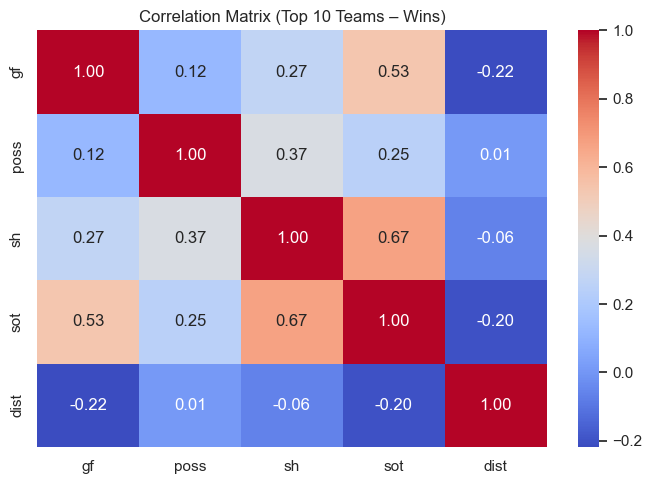

In [43]:
# Visualize the correlation matrix
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Top 10 Teams – Wins)")
plt.tight_layout()
plt.show()

The strongest positive correlation is between shots (sh) and shots on target (sot) (r = 0.68), suggesting that teams generating more opportunities also land more accurate attempts. There is a moderate correlation between shots and goals (r = 0.35), showing that higher shot volume often contributes to scoring, but not always efficiently. Possession correlates moderately with shots as well (r = 0.44), indicating that more control of the ball often leads to more attempts. Interestingly, distance covered shows weak or even negative correlations, especially with gf and sot, reinforcing the idea that winning is more about quality than quantity of physical output.

#### Categorical Relationship

This section investigates how each of the Top 10 teams by win rate performs when playing at home vs. away. By visualizing win counts across venues for each team, we uncover patterns that highlight whether certain teams are more dominant on their own turf or equally effective on the road.


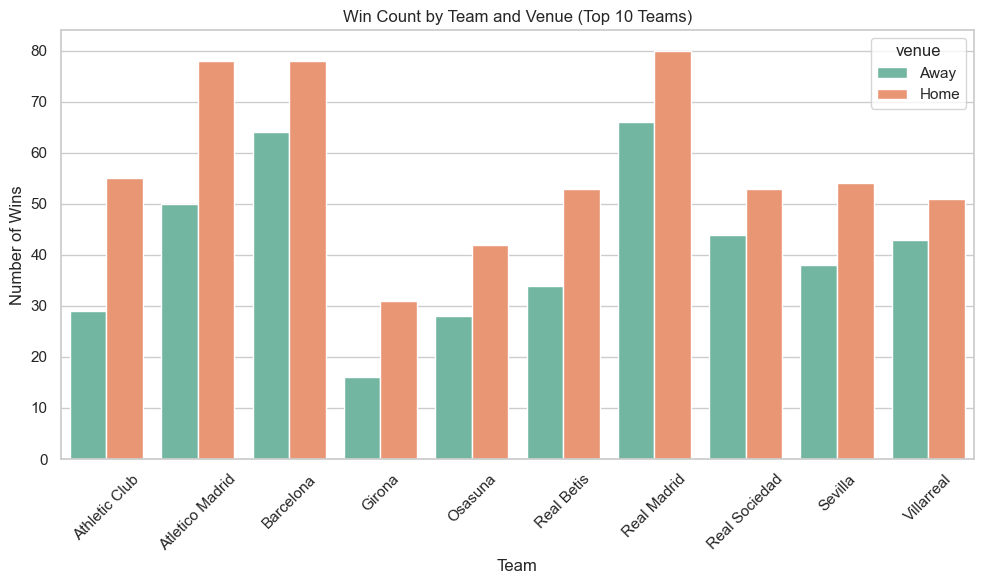

In [44]:
#Count wins by team and venue
team_venue_counts = top10_wins_df.groupby(['team', 'venue']).size().reset_index(name='win_count')

# Create grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=team_venue_counts, x='team', y='win_count', hue='venue', palette='Set2')
plt.title("Win Count by Team and Venue (Top 10 Teams)")
plt.xlabel("Team")
plt.ylabel("Number of Wins")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

The chart reveals that most top teams tend to secure more wins at home than away, benefiting from familiar conditions, crowd support, and tactical stability. Barcelona and Real Madrid, however, show relatively balanced win counts across venues, reflecting their consistency regardless of setting. In contrast, Atletico Madrid and Real Sociedad show a stronger home bias. This suggests that while elite teams win frequently overall, home advantage still plays a critical role in sustaining high win rates, though some are more resilient travelers than others.

## Modelling Analysis
### Multiple Linear Regression (Top 10 Teams – Wins)

To understand what factors contribute most to scoring goals in winning matches, we apply a Multiple Linear Regression model using key features: possession (poss), shots (sh), shots on target (sot), and distance covered (dist). This model estimates how these variables together explain the number of goals a team scores in a match.

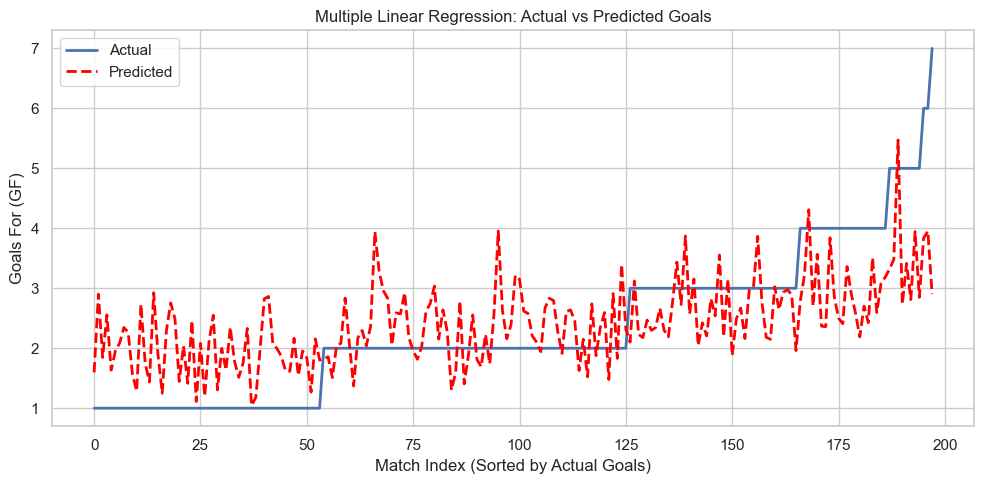

RMSE: 0.9675381895032049
R²: 0.35114219465779495


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [45]:
# Load data (assumes previous filtering already applied to top10_wins_df)
modeling_df = top10_wins_df.dropna(subset=['gf', 'poss', 'sh', 'sot', 'dist'])

# Define features and target
X = modeling_df[['poss', 'sh', 'sot', 'dist']]
y = modeling_df['gf']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Visualization
# Sort test values for a cleaner comparison
sorted_idx = np.argsort(y_test.values)
y_test_sorted = y_test.values[sorted_idx]
y_pred_sorted = y_pred_lr[sorted_idx]

# Line plot of actual vs predicted goals
plt.figure(figsize=(10, 5))
plt.plot(y_test_sorted, label='Actual', linewidth=2)
plt.plot(y_pred_sorted, label='Predicted', linestyle='--', linewidth=2, color='red')
plt.title("Multiple Linear Regression: Actual vs Predicted Goals")
plt.xlabel("Match Index (Sorted by Actual Goals)")
plt.ylabel("Goals For (GF)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate performance
lr_rmse = mean_squared_error(y_test, y_pred_lr, squared=False)
lr_r2 = r2_score(y_test, y_pred_lr)

print("RMSE:", lr_rmse)
print("R²:", lr_r2)

This means that about 35% of the variation in goals scored can be explained by the combination of possession, shots, shots on target, and distance run. While not extremely high, this shows a moderate predictive ability, particularly helpful in identifying which variables consistently contribute to successful goal scoring in winning matches.

#### Polynomial Regression Model

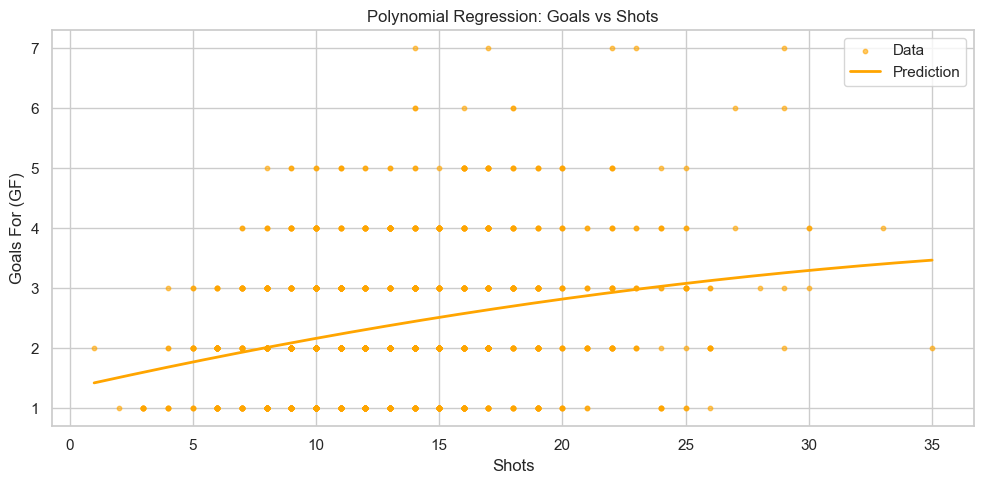

RMSE: 0.9649001718735464
R²: 0.3546756259032652


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [49]:
# Polynomial Regression pipeline
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)
y_pred_poly = poly_model.predict(X_test)

# Scatter plot with prediction curve
plt.figure(figsize=(10, 5))
plt.scatter(X_single, y_single, label='Data', s=10, alpha=0.6, color='orange')
plt.plot(x_range, y_range_pred, label='Prediction', color='orange', linewidth=2)
plt.title("Polynomial Regression: Goals vs Shots")
plt.xlabel("Shots")
plt.ylabel("Goals For (GF)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation
poly_rmse = mean_squared_error(y_test, y_pred_poly, squared=False)
poly_r2 = r2_score(y_test, y_pred_poly)

print("RMSE:", poly_rmse)
print("R²:", poly_r2)

This shows a very slight improvement over the linear model (R² went from 0.351 → 0.355). This suggests that while there may be some non-linearity in the data, the added complexity of polynomial terms only marginally improves prediction. It indicates the model is already close to the best fit that a basic structure can provide.

## Ridge Regression (with Hyperparameter Tuning)

Ridge Regression applies L2 regularization, which reduces overfitting by penalizing overly large coefficients in the model. This is especially useful when features are correlated or noisy. We tune the regularization strength (alpha) using cross-validation to find the best balance between bias and variance.

/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 0.9672185551678467
R²: 0.351570835052348
Best alpha: 100.0


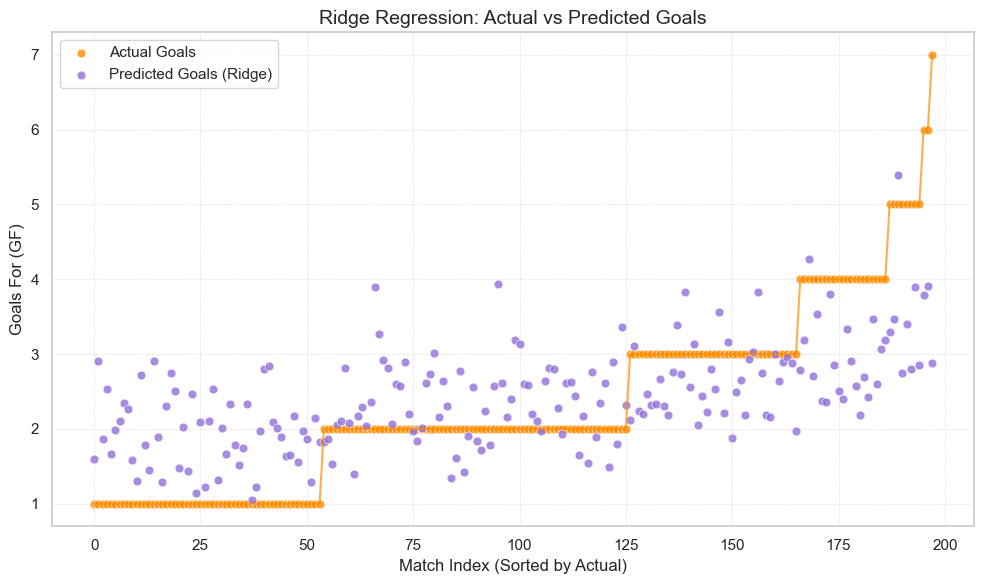

In [58]:
# Set up ridge regression and alpha grid
ridge = Ridge()
alphas = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
ridge_search = GridSearchCV(ridge, alphas, cv=5, scoring='r2')
ridge_search.fit(X_train, y_train)

# Best estimator and predictions
best_ridge = ridge_search.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

# Evaluation metrics
ridge_rmse = mean_squared_error(y_test, y_pred_ridge, squared=False)
ridge_r2 = r2_score(y_test, y_pred_ridge)
print("RMSE:", ridge_rmse)
print("R²:", ridge_r2)
print("Best alpha:", ridge_search.best_params_['alpha'])

# Sort predictions and actuals by actual values
sorted_idx = np.argsort(y_test.values)
y_test_sorted = y_test.values[sorted_idx]
y_pred_sorted = y_pred_ridge[sorted_idx]

# Plot setup
plt.figure(figsize=(10, 6))

# Actual values: orange dots + connected line
plt.plot(range(len(y_test_sorted)), y_test_sorted, color='darkorange', linewidth=1.5, alpha=0.7)
plt.scatter(range(len(y_test_sorted)), y_test_sorted,
            color='darkorange', label='Actual Goals', s=40, alpha=0.8, edgecolor='white', linewidth=0.5)

# Predicted values: purple dots
plt.scatter(range(len(y_pred_sorted)), y_pred_sorted,
            color='mediumpurple', label='Predicted Goals (Ridge)', s=40, alpha=0.8, edgecolor='white', linewidth=0.5)

# Styling
plt.title("Ridge Regression: Actual vs Predicted Goals", fontsize=14)
plt.xlabel("Match Index (Sorted by Actual)", fontsize=12)
plt.ylabel("Goals For (GF)", fontsize=12)
plt.legend(frameon=True)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()

The Ridge model performs similarly to the basic linear and polynomial models, with no significant performance gain (same R² = 0.35). However, Ridge adds model robustness and helps mitigate multicollinearity or overfitting risks. Its main benefit here is stability, not predictive power improvement.

# Conclusion

The analysis shows that teams win by being offensively efficient. Most victories occur when teams score at least 2 goals, take around 10–15 shots, and hit the target 4–6 times. These numbers are consistent across teams, especially those with high win rates. While possession helps, it’s not as strong a predictor as shots on target or goals scored, meaning that creating and finishing chances matters more than simply controlling the game. Additionally, teams don't need to run more (distance covered had weak correlation), highlighting that quality execution beats physical volume. Whether at home or away, teams that finish well tend to win.